In [1]:
import numpy as np
from epyt import epanet
from ray.rllib.algorithms.algorithm import Algorithm

from esc.water_usage import MINUTES_PER_DAY, TYPICAL_BUILDING_MEAN_WATER_CONSUMPTION_LITER_PER_MINUTE, relative_occupant_water_demand
from esc.electricity_rates import electricity_rate


In [2]:
algo = Algorithm.from_checkpoint('../data/models/test01/checkpoint_000851')

2022-11-21 16:56:00,769	WARNING deprecation.py:47 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-11-21 16:56:00,772	WARNING algorithm.py:2531 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Algorithm.train()`. Instead, you will have to call `Algorithm.evaluate()` manually in order to trigger an evaluation run.
2022-11-21 16:56:01,785	INFO worker.py:1528 -- Started a local Ray instance.


(RolloutWorker pid=55039) EPANET version 20200 loaded (EPyT version 1.0.1).
(RolloutWorker pid=55039) Input File BUILDING.inp loaded successfully.
(RolloutWorker pid=55039) 
(RolloutWorker pid=55041) EPANET version 20200 loaded (EPyT version 1.0.1).
(RolloutWorker pid=55041) Input File BUILDING.inp loaded successfully.
(RolloutWorker pid=55041) 


(RolloutWorker pid=55037) 2022-11-21 16:56:18,807	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


(RolloutWorker pid=55037) EPANET version 20200 loaded (EPyT version 1.0.1).
(RolloutWorker pid=55037) Input File BUILDING.inp loaded successfully.
(RolloutWorker pid=55037) 
(RolloutWorker pid=55038) EPANET version 20200 loaded (EPyT version 1.0.1).
(RolloutWorker pid=55038) Input File BUILDING.inp loaded successfully.
(RolloutWorker pid=55038) 
(RolloutWorker pid=55040) EPANET version 20200 loaded (EPyT version 1.0.1).
(RolloutWorker pid=55040) Input File BUILDING.inp loaded successfully.
(RolloutWorker pid=55040) 


2022-11-21 16:56:25,637	WARNING deprecation.py:47 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-11-21 16:56:25,638	WARNING algorithm.py:2531 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Algorithm.train()`. Instead, you will have to call `Algorithm.evaluate()` manually in order to trigger an evaluation run.
2022-11-21 16:56:28,135	INFO trainable.py:164 -- Trainable.setup took 27.369 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-11-21 16:56:28,136	WARNING util.py:66 -- Install gputil for GPU system monitoring.


In [3]:
d = epanet("../networks/BUILDING.inp")

(RolloutWorker pid=55277) EPANET version 20200 loaded (EPyT version 1.0.1).
(RolloutWorker pid=55277) Input File BUILDING.inp loaded successfully.
(RolloutWorker pid=55277) 
EPANET version 20200 loaded (EPyT version 1.0.1).
Input File BUILDING.inp loaded successfully.



(RolloutWorker pid=55277) 2022-11-21 16:56:28,082	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


In [4]:
SIMULATION_DURATION_S = 172800
SIMULATION_TIMESTEP_S = 60
N_SIMULATION_STEPS = SIMULATION_DURATION_S / SIMULATION_TIMESTEP_S

d.setTimeSimulationDuration(SIMULATION_DURATION_S) # 48 hour duration
d.setTimeHydraulicStep(SIMULATION_TIMESTEP_S) # Time step every minute
d.setTimePatternStep(SIMULATION_TIMESTEP_S) # Pattern step every minute

In [5]:
# Add time-dependent pattern for occupant demand to the outflow junction
# Sample the demand for every minute of the day
demand_sample_24h = relative_occupant_water_demand(np.arange(N_SIMULATION_STEPS))
d.addPattern("relative_occupant_demand", demand_sample_24h)
d.setNodeJunctionData(1, 0, TYPICAL_BUILDING_MEAN_WATER_CONSUMPTION_LITER_PER_MINUTE, 'relative_occupant_demand')

In [6]:
d.deleteControls()
tankID = 'T1'
pumpID = 'PUMP'

tankIndex = d.getNodeIndex(tankID)
pumpIndex = d.getLinkIndex(pumpID)
tankElevation = d.getNodeElevations(tankIndex)

# Hydraulic analysis STEP-BY-STEP.
d.openHydraulicAnalysis()
d.initializeHydraulicAnalysis(0)

tstep = 1
i = 0
T, P, F, S, E = [], [], [], [], []

# CONTROLS.
Below = 0.07
Above = 0.08
tankHead = []
while tstep > 0:

    H = d.getNodeHydraulicHead()
    tankHead.append(H[tankIndex - 1] - tankElevation)

    action = algo.compute_single_action(observation=np.array([electricity_rate(i), relative_occupant_water_demand(i), tankHead[-1]]))
    d.setLinkStatus(pumpIndex, action)
    i += 1

    t = d.runHydraulicAnalysis()

    S.append(d.getLinkStatus(pumpIndex))
    F.append(d.getLinkFlows())
    P.append(d.getNodePressure())
    E.append(d.getLinkEnergy(pumpIndex))
    T.append(t)

    tstep = d.nextHydraulicAnalysisStep()

d.closeHydraulicAnalysis()
print("Hydraulic Analysis completed succesfully.")

Hydraulic Analysis completed succesfully.


/opt/homebrew/Caskroom/mambaforge/base/envs/engineering-smart-cities/lib/python3.10/site-packages/epyt/epanet.py:10195: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  bar = plt.colorbar(scal, orientation='horizontal', shrink=0.7, pad=0.05)
/opt/homebrew/Caskroom/mambaforge/base/envs/engineering-smart-cities/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


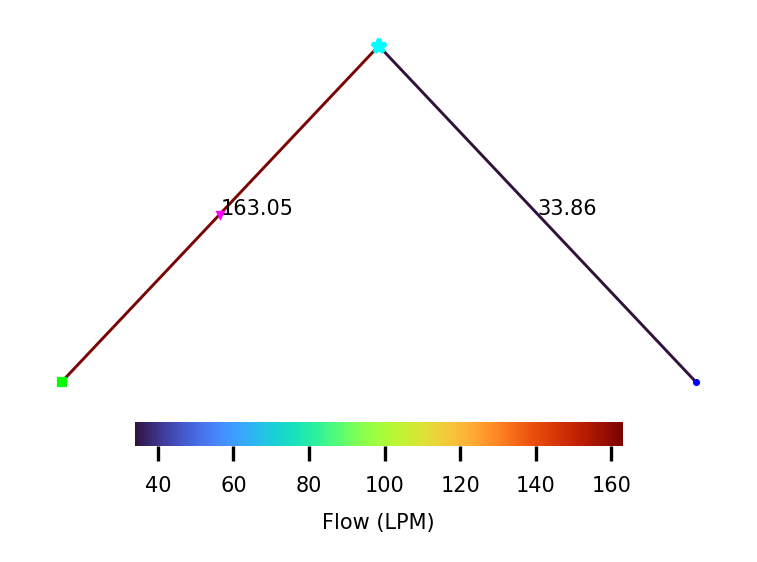

In [7]:
_ = d.plot(flow=F[48], flow_text=True)

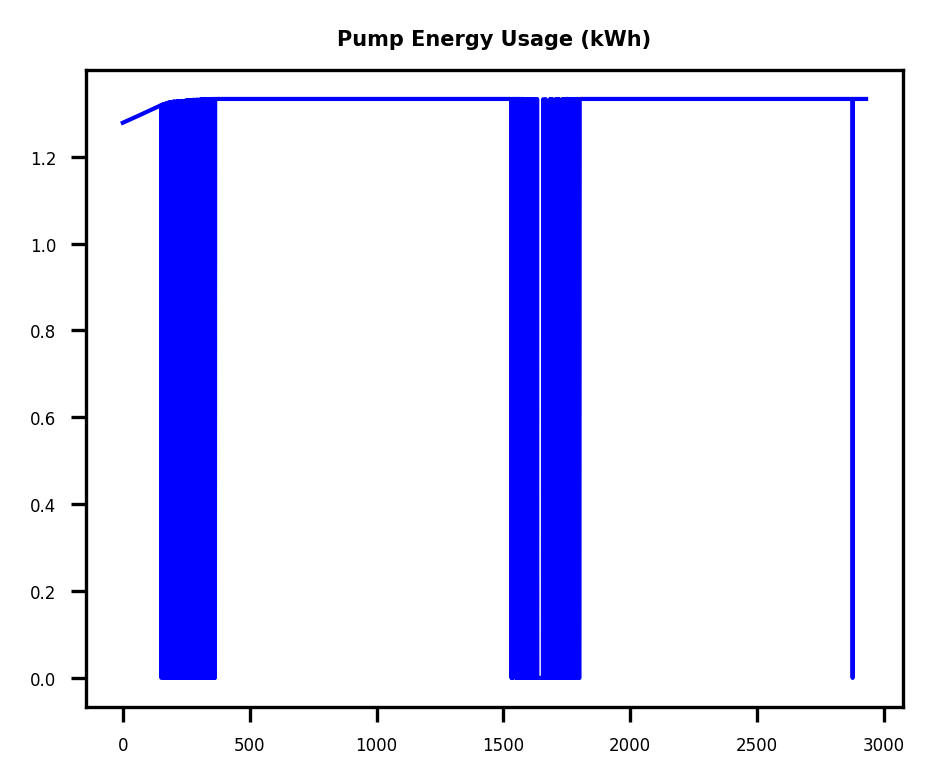

In [8]:
d.plot_ts(Y=E, title="Pump Energy Usage (kWh)", marker=False)

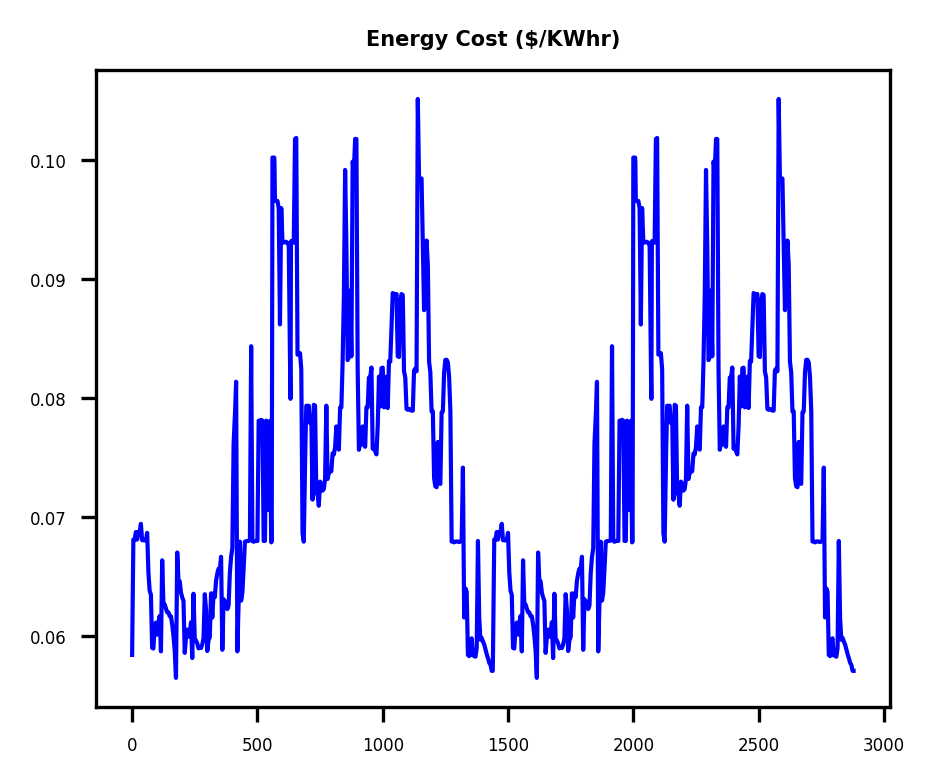

In [9]:
d.plot_ts(Y=electricity_rate(np.arange(N_SIMULATION_STEPS)), title="Energy Cost ($/KWhr)", marker=False)

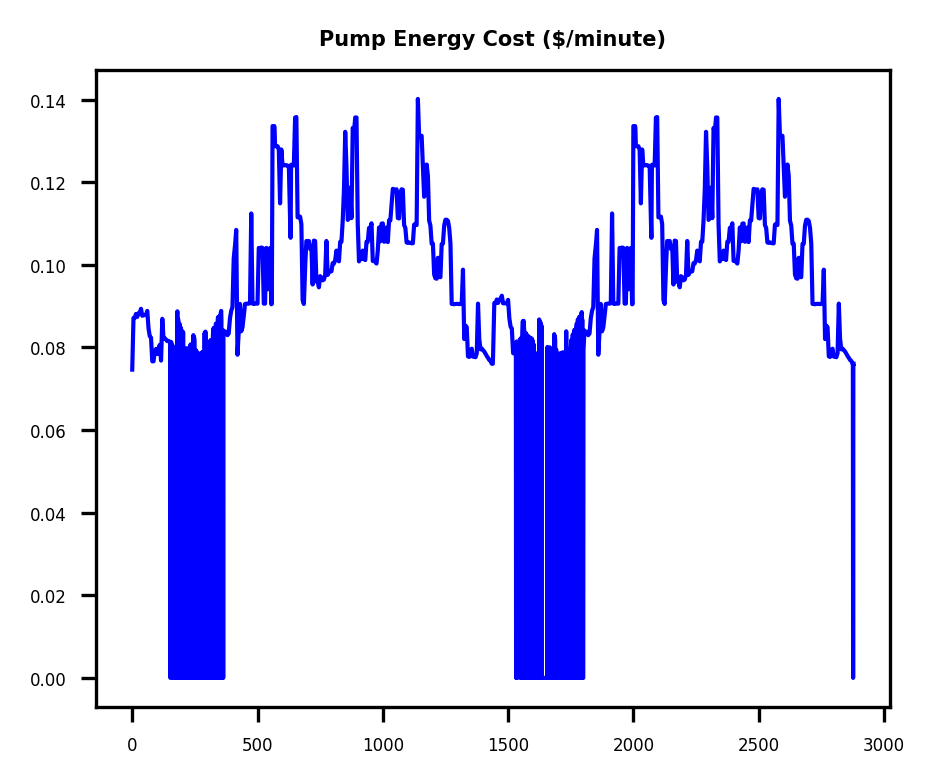

In [10]:
d.plot_ts(Y=np.array(E[:2880]) * electricity_rate(np.arange(N_SIMULATION_STEPS)), title="Pump Energy Cost ($/minute)", marker=False)

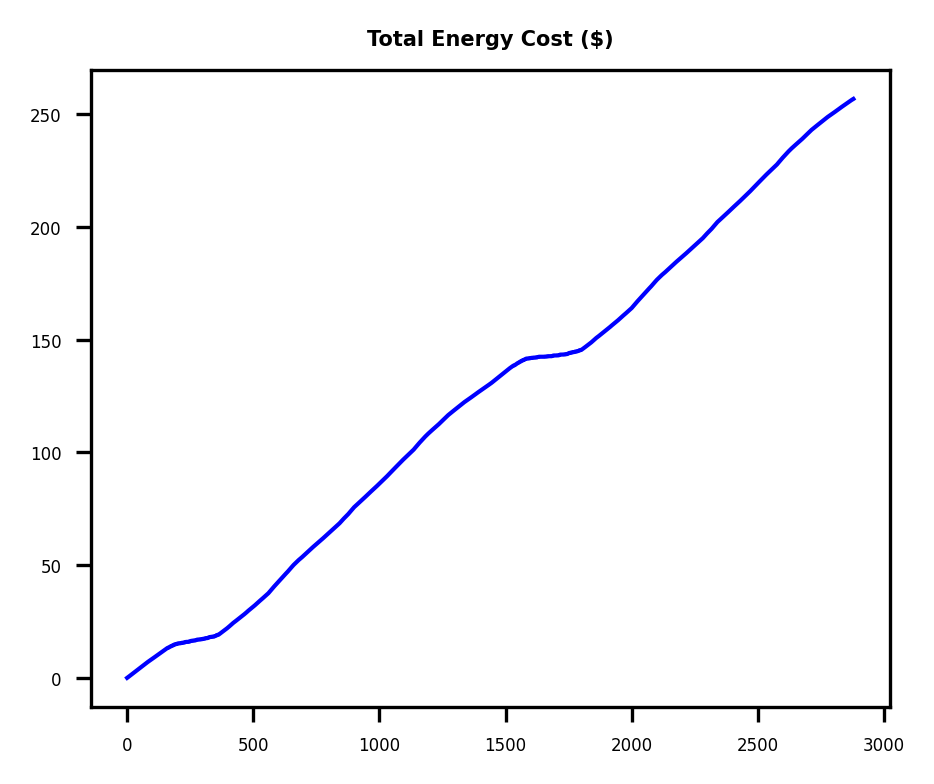

In [14]:
d.plot_ts(Y=np.cumsum(np.array(E[:2880]) * electricity_rate(np.arange(N_SIMULATION_STEPS))), title="Total Energy Cost ($)", marker=False)

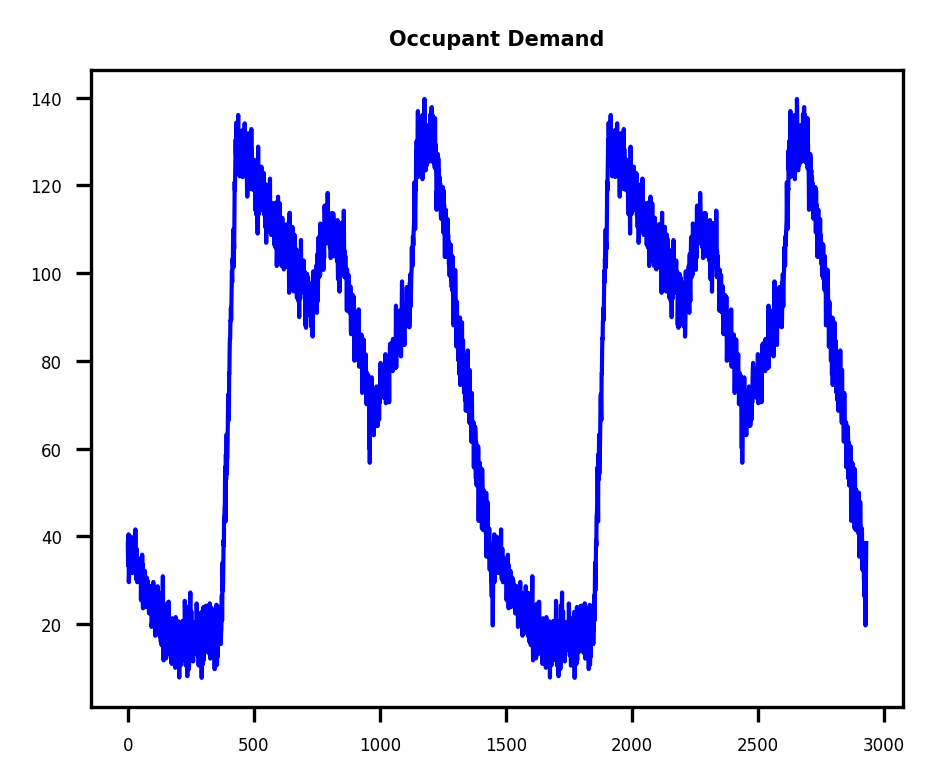

In [15]:
d.plot_ts(Y=np.array(F)[:, 0], title="Occupant Demand", marker=False)

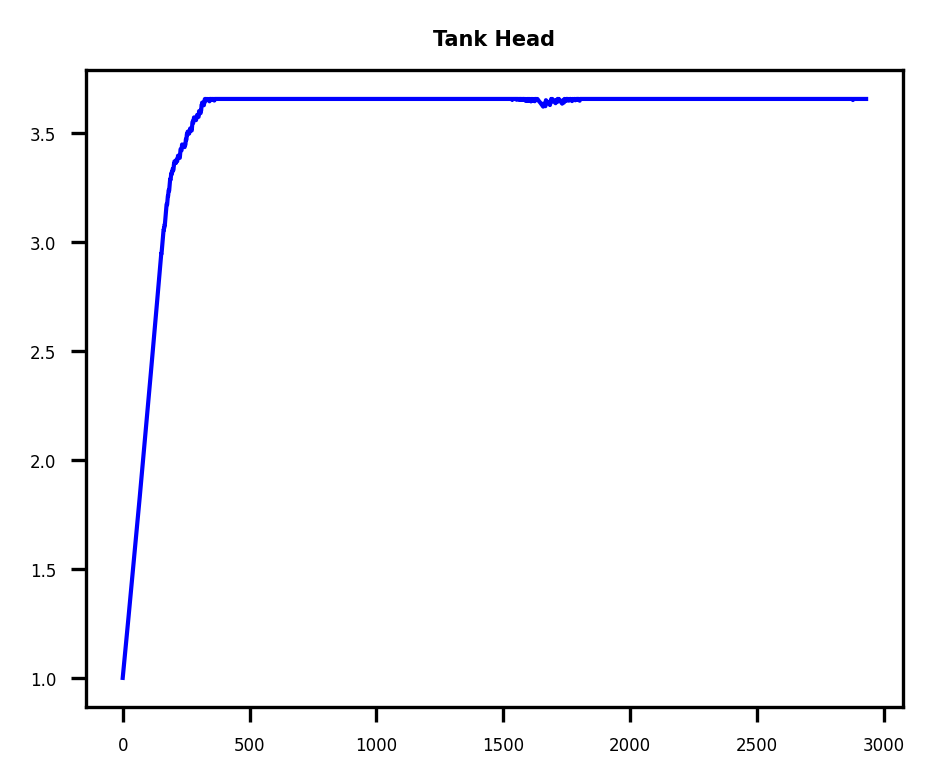

In [16]:
d.plot_ts(Y=tankHead, title='Tank Head', marker=False)